# Fake news detection using ML 


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [17]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [18]:
fake.shape

(23481, 4)

In [19]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [20]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [21]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [22]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [23]:
# Check the data
data.head()

,title,text,subject,date,target
0,Why Doctor Who Made Bizarre Race Rant Against...,"A Denver, Colorado doctor under fire for a biz...",News,"December 1, 2016",fake
1,‘God Is Gay’: SNL Destroys ‘Religious Freedom...,What would you do if a gay couple requested th...,News,"April 17, 2016",fake
2,BREAKING: Acting FBI Director McCabe Contradi...,Acting FBI Director Andrew McCabe testified to...,News,"May 11, 2017",fake
3,U.S. House Speaker backs intelligence panel ch...,WASHINGTON (Reuters) - The top Republican in C...,politicsNews,"March 28, 2017",true
4,Police arrest woman in Tanzania over video of ...,DAR ES SALAAM (Reuters) - Police in Tanzania h...,worldnews,"December 2, 2017",true


In [24]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Why Doctor Who Made Bizarre Race Rant Against...,"A Denver, Colorado doctor under fire for a biz...",News,fake
1,‘God Is Gay’: SNL Destroys ‘Religious Freedom...,What would you do if a gay couple requested th...,News,fake
2,BREAKING: Acting FBI Director McCabe Contradi...,Acting FBI Director Andrew McCabe testified to...,News,fake
3,U.S. House Speaker backs intelligence panel ch...,WASHINGTON (Reuters) - The top Republican in C...,politicsNews,true
4,Police arrest woman in Tanzania over video of ...,DAR ES SALAAM (Reuters) - Police in Tanzania h...,worldnews,true


In [25]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,"A Denver, Colorado doctor under fire for a biz...",News,fake
1,What would you do if a gay couple requested th...,News,fake
2,Acting FBI Director Andrew McCabe testified to...,News,fake
3,WASHINGTON (Reuters) - The top Republican in C...,politicsNews,true
4,DAR ES SALAAM (Reuters) - Police in Tanzania h...,worldnews,true


In [26]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,"a denver, colorado doctor under fire for a biz...",News,fake
1,what would you do if a gay couple requested th...,News,fake
2,acting fbi director andrew mccabe testified to...,News,fake
3,washington (reuters) - the top republican in c...,politicsNews,true
4,dar es salaam (reuters) - police in tanzania h...,worldnews,true


In [27]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [28]:
# Check
data.head()

,text,subject,target
0,a denver colorado doctor under fire for a biza...,News,fake
1,what would you do if a gay couple requested th...,News,fake
2,acting fbi director andrew mccabe testified to...,News,fake
3,washington reuters the top republican in cong...,politicsNews,true
4,dar es salaam reuters police in tanzania have...,worldnews,true


In [29]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\archi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
data.head()

,text,subject,target
0,denver colorado doctor fire bizarre racial ran...,News,fake
1,would gay couple requested bake cake probably ...,News,fake
2,acting fbi director andrew mccabe testified to...,News,fake
3,washington reuters top republican congress tue...,politicsNews,true
4,dar es salaam reuters police tanzania arrested...,worldnews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


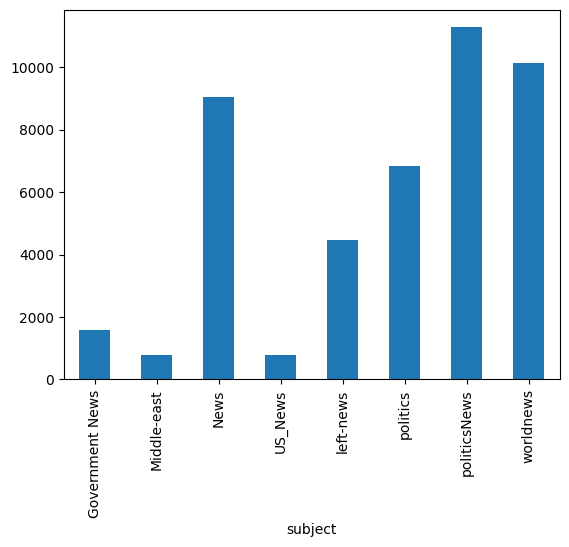

In [31]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


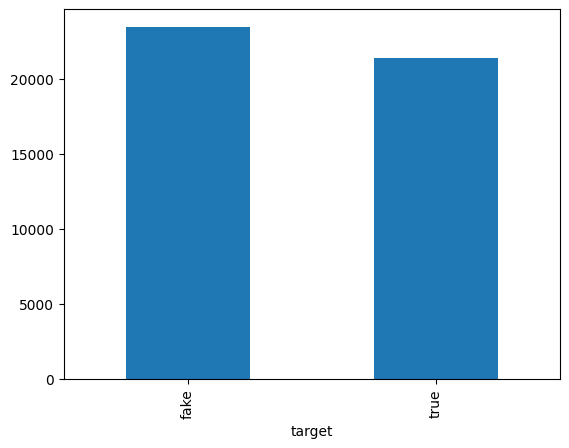

In [32]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

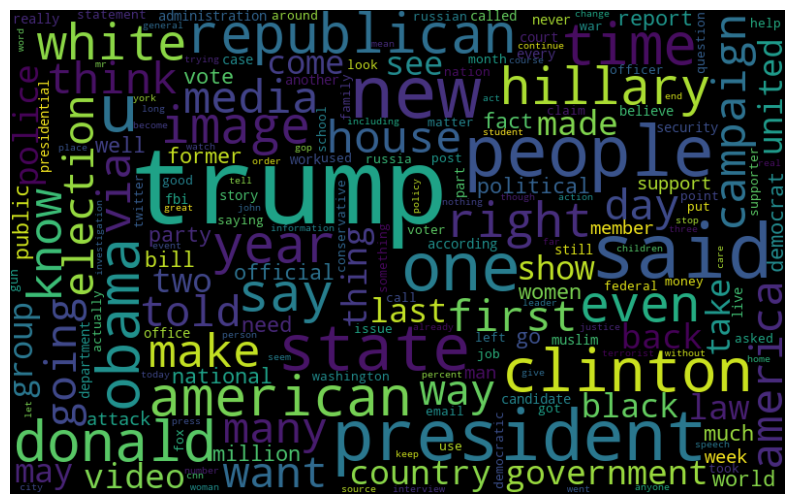

In [34]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

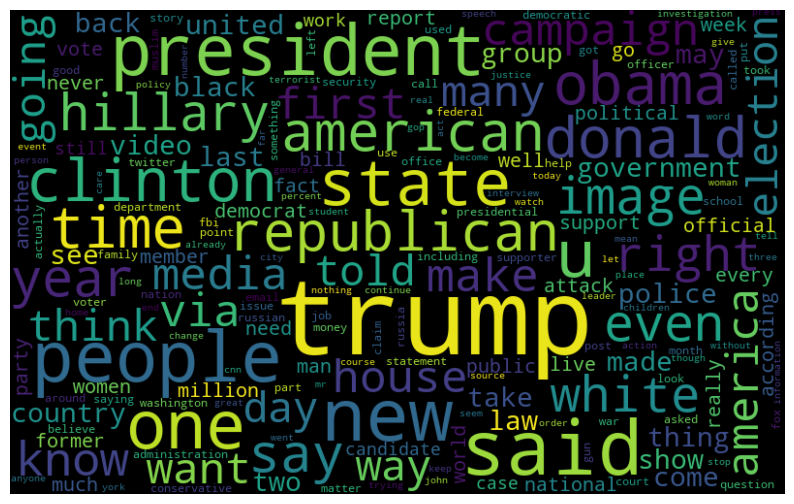

In [35]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

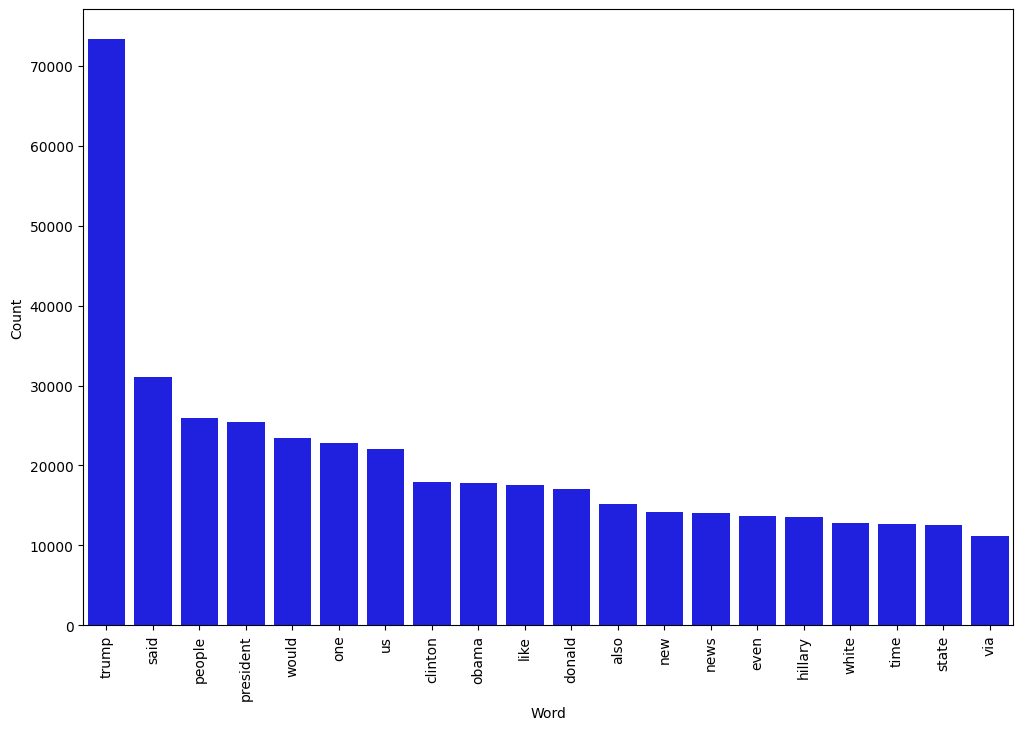

In [37]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

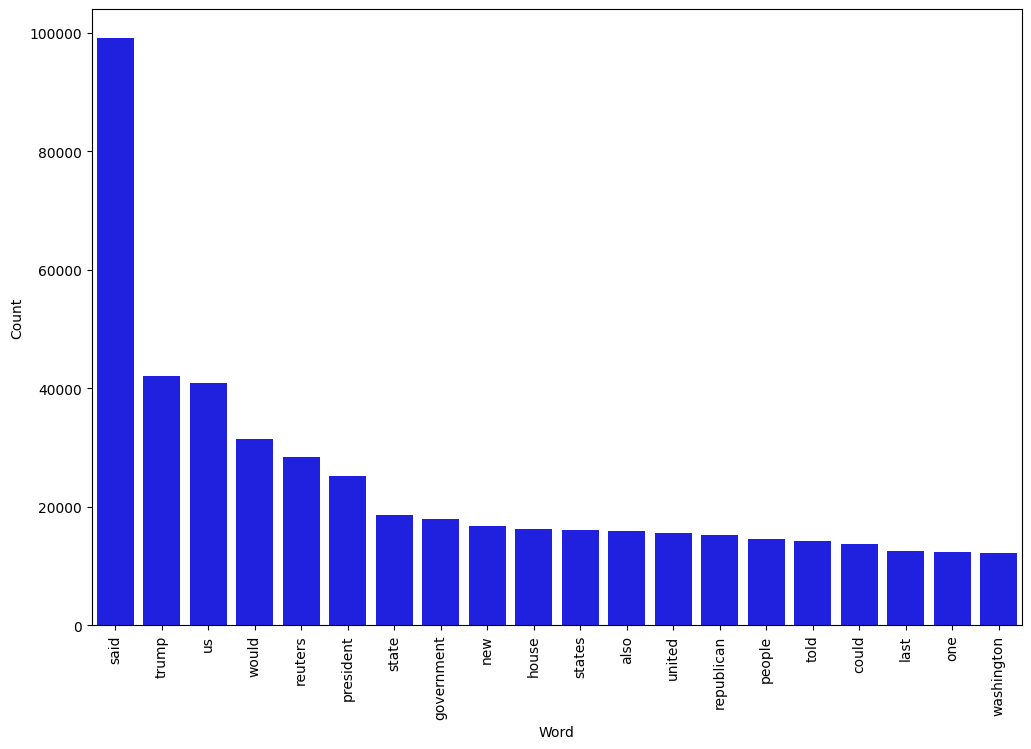

In [38]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [39]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [40]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [41]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.31%


Confusion matrix, without normalization


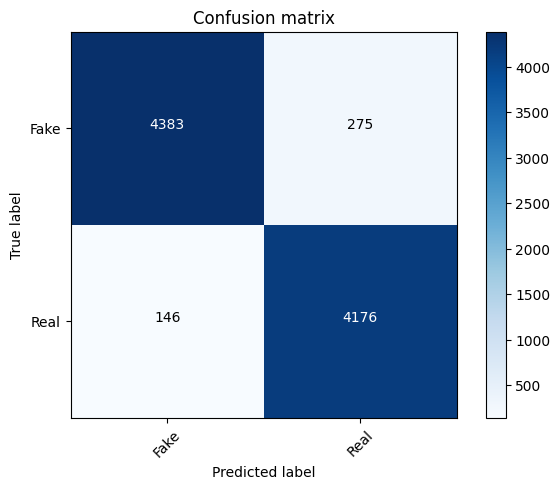

In [42]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.9%


Confusion matrix, without normalization


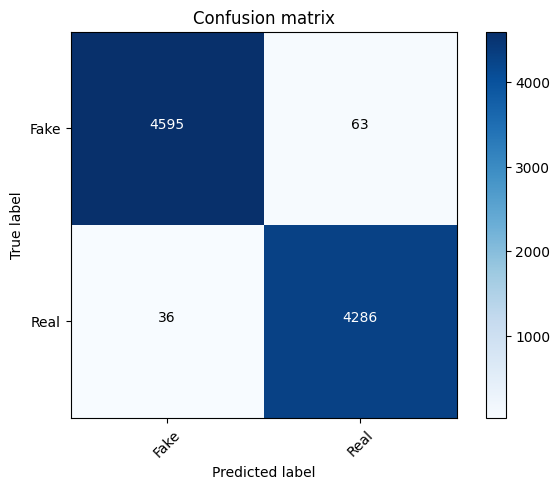

In [44]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [45]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.65%


Confusion matrix, without normalization


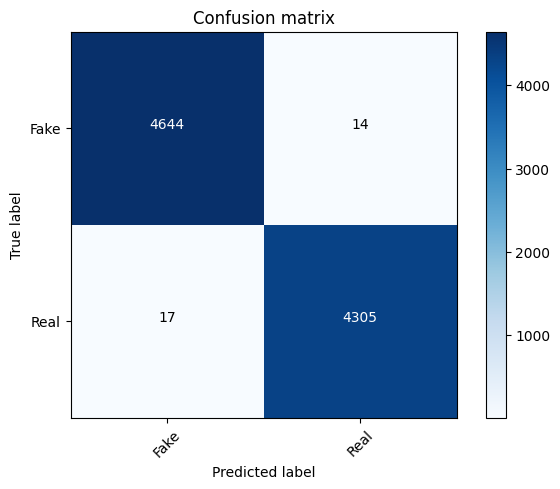

In [46]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [47]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.05%


Confusion matrix, without normalization


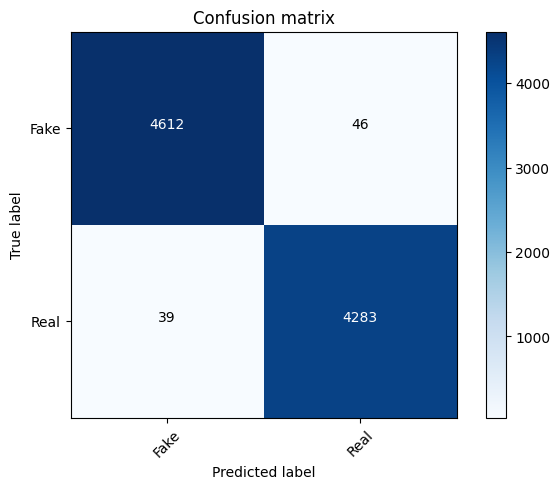

In [48]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [49]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 99.55%


Confusion matrix, without normalization


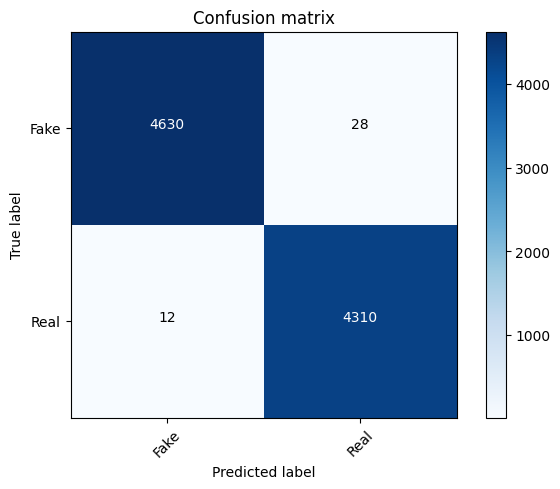

In [50]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x29cd445cef0>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

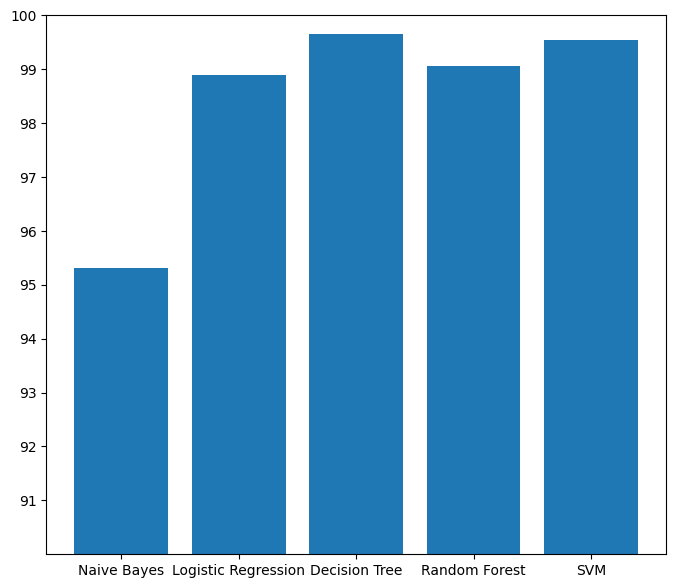

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))